

# Walk Cycle detection from a linear accelerometer sensor

## Introduction

   A linear accelerometer measures the relative acceleration of a body (relative to free fall) which is represented across three dimensions. The signal retreived from the sensor data is time vs 3 axes. This sensor is sensitive to both acceleration and orientation changes of the object. The goal of this project is to extract walk cycles by using the features of the three dimensional time series signal. An android app was used to record the walk, the smartphone was placed in the left trouser pocket of the subject (myself) and the walk was recorded for a period of about 30 seconds. Walk was split into three sections first section starting from a period of 5 to 12 seconds where the subject walked with a consistent slow pace, a pause (stand still) for a period of two seconds and walking at a faster pace with a change in direction. Since this series have strong time domain characteristics, the analysis was carried out in the time domain. Two models - one statistical (least squares regression with lagged components) and one machine learning (1-nearest neighbour with Dynamic Time Warping distance) with pre-signal processing were implemented. 

In [18]:
#import all packages
import pywt
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import scipy as sc
from scipy import signal
from dtw import dtw
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import sklearn
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime
import plotly.offline as pyo
import json
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
import plotly.tools as tls

## Signal Processing - labelling the time series training data
### Resampling and Interpolation

   The android phone gives out a signal of unequal intervals. In order to equally space the time series, the signal was resampled - down sampled to an interval of 6 milliseconds which was initially in the order of 3 milliseconds. Mean function was used for grouping the data in a particular interval. When a particular interval does not contain any value, it returns missing values. This is imputed with a linear interpolater function. 

In [19]:
#function resampling to regularize the time series and also 
def regularize(data_frame):
    time_i = data_frame['time'][0:]
    floatseconds = map(float,time_i)
    data_frame.index = pd.to_timedelta(floatseconds,unit='s') 
    data_frame = data_frame.iloc[:,1:4]
    res_1 = data_frame.resample('6L').mean()
    res = res_1.interpolate()
    return res

### Smoothing by sliding window variance

   A sliding with a window size of (40 x 0.006) = 0.24 seconds was used to calculate the variance and replacing it at the center of the window. Variance was an important feature to extract walk cycles as the variance plot visually indicated the walking cycles in the train data. 

In [20]:
#function calculating variance by a sliding window
def variance_window(data_frame):
    res_scale = data_frame - data_frame.mean()
    res_scale['var'] = np.sqrt((res_scale['ax']**2) + (res_scale['ay']**2) + (res_scale['az']**2))
    smoothed = pd.rolling_window(res_scale['var'], window = 40, center = True, win_type = 'boxcar',mean = True) 
    smoothed = pd.DataFrame(smoothed)
    smoothed = pd.concat([res_scale['ax'], res_scale['ay'], res_scale['az'], smoothed], axis=1)
    return smoothed

### Thresholding

   Variance plot was visually analyzed and the summary statistics showed that a variance median threshold would bring out the walk cycles. Hence, signal was thresholded at the median of the variance - anything above the threshold was labelled as a walk cycle and anything below the threshold was labelled as a non-walk. 

In [21]:
#function thresholding variance and classifying based on the variance
def threshold(data_frame):
    data_frame['cycle'] = np.where(data_frame['var'] > data_frame['var'].median(),1,0)
    #plt.plot(smoothed['cycle'])
    only_cycle = data_frame[data_frame['cycle'] == 1]
    return data_frame, only_cycle

In [22]:
# main function

#data read
series_1 = pd.read_csv('rec6.csv')
series_1.head()

,time,ax,ay,az
0,0.006,0.30,0.20,-1.08
1,0.007,-0.07,0.18,-1.07
2,0.011,-0.28,0.35,-0.93
3,0.016,-0.36,0.36,-0.70
4,0.021,-0.32,0.37,-0.39


## Exploratory Signal Analysis
    
   The time and frequency domain characteristics of the time series data from the accelerometer was explored. A plot of the three dimensions in the time axis, spectral characteristics across time and the power spectrum was visualized to eyeball the walk cycles. From the box plot shown below and the variance plot that follows the time series plot, it can be seen that variances below the median contribute to the standing signal(non-walking) and hence the median threshold.  

/nfs/nfs5-insecure/home/insecure-ro/software/rhel7_x86_64/python2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(win_type=boxcar,center=True,window=40,axis=0).mean()



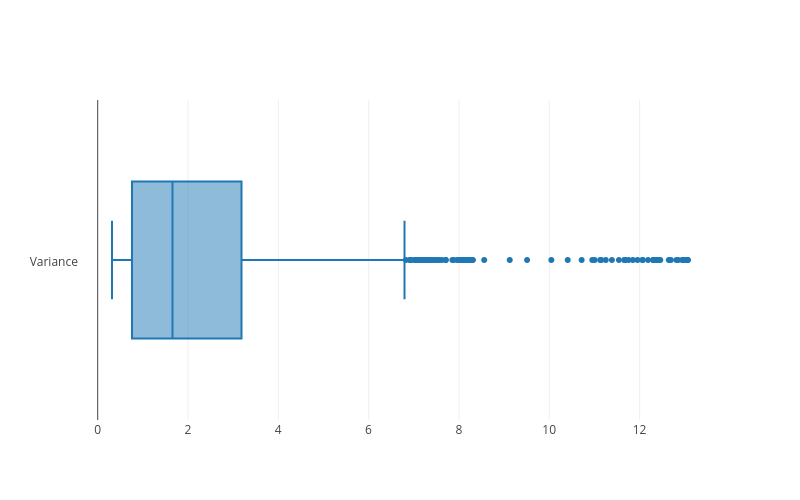

In [26]:
#function calls for regularizing, interpolating, smoothing and thresholding
res = regularize(series_1)
smoothed = variance_window(res)
smoothed_cycles, cycle_only = threshold(smoothed)


#tls.set_credentials_file(username='minsrini', api_key='GY3NIdLigUc8p6dXpdmr')
py.sign_in('minsrini', 'oJGkU5LmludCy1lV51hr')
#box plot function
pyo.init_notebook_mode(connected=True)
def plot_box(df):
    var = go.Box(x=df['var'], name = "Variance")
    data= [var]
    return data
fig0 = plot_box(smoothed_cycles)
#pyo.iplot(fig0)
py.image.ishow(fig0, width = 800)

### Time series visualization

   The first plot shown below is the equal interval time series plot of the three axes. The spike in the start is due the noise created while getting the phone into the pocket and the final spike is the end of the walk session. There is a flat period in between where the subject was not walking. 

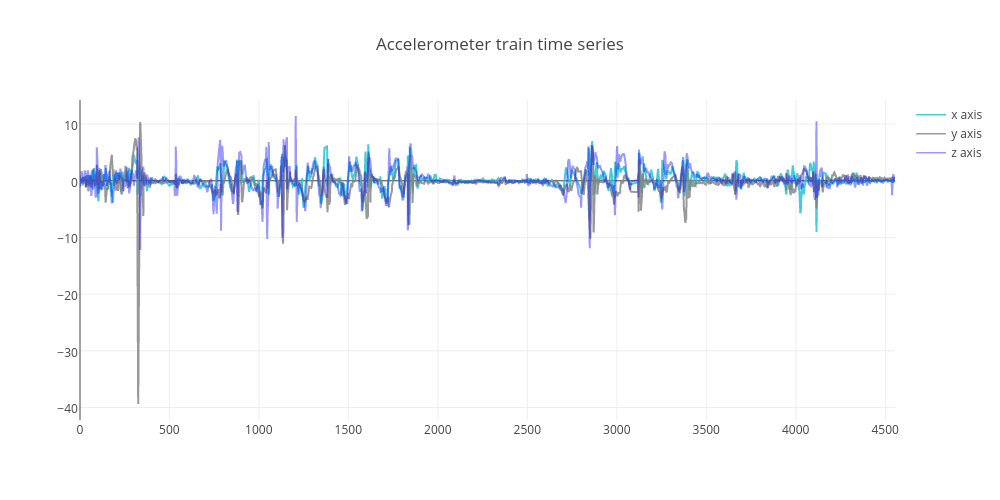

In [25]:
#pyo.init_notebook_mode(connected=True)
def plot_ts(df):
    x = go.Scatter(
                y=df['ax'],
                name = "x axis",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

    y = go.Scatter(
                y=df['ay'],
                name = "y axis",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)
    
    z = go.Scatter(
                y=df['az'],
                name = "z axis",
                line = dict(color = 'blue'),
                opacity = 0.4)

    data = [x,y,z]

    layout = dict(
        title = "Accelerometer train time series",
        xaxis = dict(
            range = ['0000-00-00 00:00:00.006','0000-00-00 00:00:32'])
    )

    fig = dict(data=data, layout=layout)
    return fig
fig = plot_ts(res)
#pyo.iplot(fig, filename = "Accelerometer train time series")
py.image.ishow(fig, width = 1000)

### Variance and Cycle Plot
   On plotting the variance across time (shown below), cycles become visually clear. The cycle plot gives us a picture of the period of the walk. 


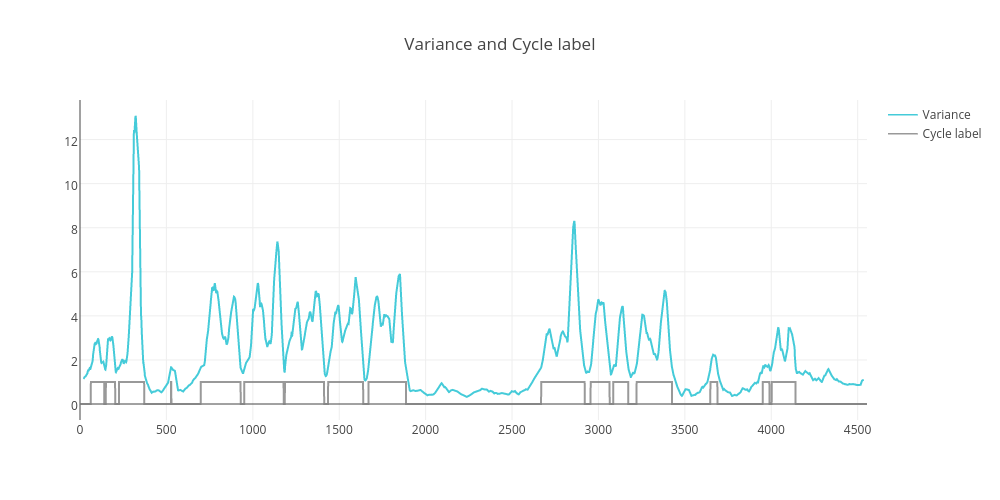

In [27]:
def plot_var(df):
    trace_x = go.Scatter(
                y=df['var'],
                name = "Variance",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

    trace_y = go.Scatter(
                y=df['cycle'],
                name = "Cycle label",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)
    data = [trace_x,trace_y]

    layout = dict(
        title = "Variance and Cycle label",
        xaxis = dict(
            range = ['0000-00-00 00:00:00.006','0000-00-00 00:00:32'])
    )

    fig = dict(data=data, layout=layout)
    return fig

fig2 = plot_var(smoothed_cycles)
#pyo.iplot(fig2, filename = "Variance plot")
py.image.ishow(fig2,width=1000)

## Learning the cycles

### Least square regression
   Now that the time series data is labelled, we can try to learn the cycles from the raw tri-axes data (ignoring the variance). Two methods were tried. A statistical least squared regression model with lagged components (a lag of 3 time points) of the dependent variable (cycle label) and independent variables (tri axes data) was trained. This model was then used to predict the walk cycles on test data. 

In [28]:
#function to extract time lagged features
def lagged_features(df):
    wo_var  = df[['ax','ay','az','cycle']]
    appended_data = []
    for column in wo_var:
        X = (pd.concat([df[column].shift(i) for i in range(4)], axis=1,
               keys=[column] + [column+'_L%s' % i for i in range(1, 4)])
        .dropna())
        appended_data.append(X)
    appended_data = pd.concat(appended_data, axis=1)
    return appended_data

#function call
appended_data = lagged_features(smoothed_cycles)
#Ols model fit
ols_model = smf.ols('cycle ~ ax + ax_L1 + ax_L2 + ax_L3 + ay_L1 + ay_L2 + ay_L3 + az_L1 + az_L2 + az_L3 + ay + az', data=appended_data.assign(trend=np.arange(len(appended_data))))
fit_model = ols_model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  cycle   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     20.50
Date:                Fri, 28 Apr 2017   Prob (F-statistic):           1.77e-44
Time:                        01:17:38   Log-Likelihood:                -3183.5
No. Observations:                4552   AIC:                             6393.
Df Residuals:                    4539   BIC:                             6477.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4960      0.007     68.623      0.000       0.482       0.510
ax             0.0464      0.022      2.135      0.033       0.004       0.089
ax_L1         -0.0055      0.040     -0.136      0.892      -0.084       0.073
ax_L2         -0.0275      0.041     -0.678      0.498      -0.107       0.052
ax_L3          0.0358      0.022      1.636      0.102      -0.007       0.079
ay_L1          0.0330      0.030      1.107      0.268      -0.025       0.092
ay_L2          0.0185      0.030      0.627      0.530      -0.039       0.076
ay_L3         -0.0397      0.015     -2.578      0.010      -0.070      -0.010
az_L1         -0.0146      0.021     -0.710      0.478      -0.055       0.026
az_L2         -0.0057      0.021     -0.279      0.780      -0.046       0.035
az_L3          0.0164      0.012      1.331      0.183      -0.008       0.041
ay            -0.0534      0.016     -3.416      0.001      -0.084      -0.023
az             0.0263      0.012      2.149      0.032       0.002       0.050
==============================================================================
Omnibus:                       10.766   Durbin-Watson:                   0.036
Prob(Omnibus):                  0.005   Jarque-Bera (JB):              652.215
Skew:                           0.119   Prob(JB):                    2.36e-142
Kurtosis:                       1.161   Cond. No.                         34.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model fit
   From the significance values, it can be seen that the intercept, ax, ay_L3, ay and az were the only significant variables. The R squared is very low and it suggests a lack of fit, but we are concerned only about the predictions of the cycles. 

#### Predictions and evaluation
   Test data was read into the system and was subject to pre-signal processing. The predictions were converted to binary values using a median threshold. The classification report is shown below with the evaluation metrics. The first plot gives the variance thresholded cycles and the plot below that shows the predictions of cycles from time components (variance ignored). 

In [32]:
#test signal read and pre-processing
test_data = pd.read_csv('rec7_test_accelerometer.csv')
test_res = regularize(test_data)
test_smoothed = variance_window(test_res)
test_smoothed_cycles, test_cycle_only = threshold(test_smoothed)

/nfs/nfs5-insecure/home/insecure-ro/software/rhel7_x86_64/python2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(win_type=boxcar,center=True,window=40,axis=0).mean()



             precision    recall  f1-score   support

    class 0       0.62      0.61      0.62      2220
    class 1       0.61      0.61      0.61      2181

avg / total       0.61      0.61      0.61      4401



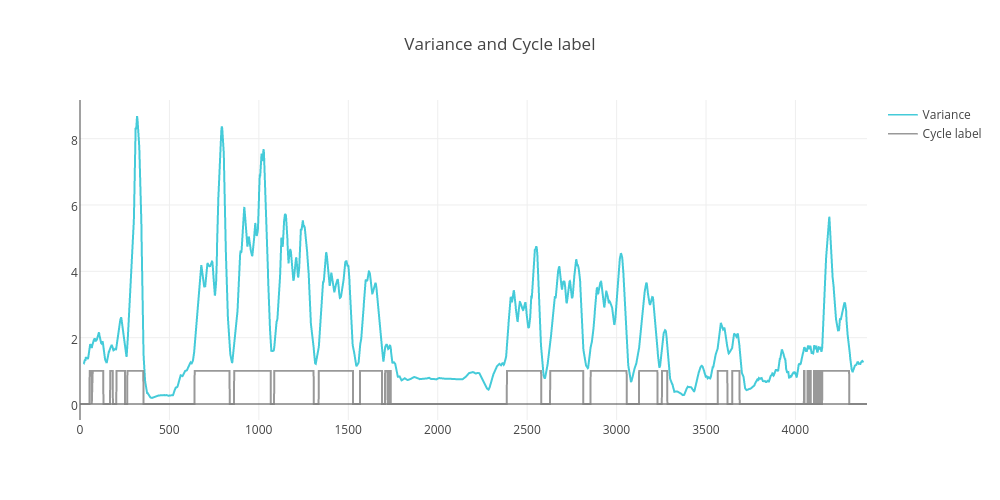

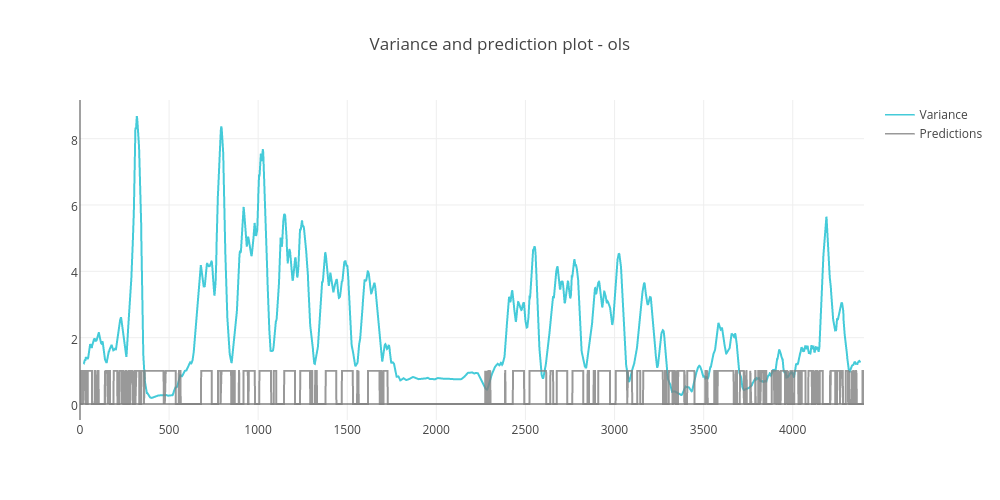

In [34]:
#function call for lagged features - test data
test_appended_data = lagged_features(test_smoothed)

#Predictions for the test data using least squares regression
test_smoothed['preds_ols'] = pd.DataFrame(fit_model.predict(test_appended_data))
test_smoothed['preds_ols_bin'] = np.where(test_smoothed['preds_ols'] > test_smoothed['preds_ols'].median(),1,0)

#test_smoothed['preds_ols'].median()
target_names = ['class 0', 'class 1']
print(classification_report(test_smoothed['cycle'],test_smoothed['preds_ols_bin'], target_names= target_names))

#Superimposed plot of variance and variance thresholded cycles detected on test data
fig3 = plot_var(test_smoothed)

#pyo.iplot(fig3, filename = "Variance plot")
py.image.ishow(fig3,width=1000)

#Superimposed plot of variance and least squares model detected cycles on test data
def plot_preds(df):
    trace_x = go.Scatter(
                y=df['var'],
                name = "Variance",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

    trace_y = go.Scatter(
                y=df['preds_ols_bin'],
                name = "Predictions",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)
    data = [trace_x,trace_y]

    layout = dict(
        title = "Variance and prediction plot - ols",
        xaxis = dict(
            range = ['0000-00-00 00:00:00.006','0000-00-00 00:00:32'])
    )

    fig = dict(data=data, layout=layout)
    return fig

fig4 = plot_preds(test_smoothed)
#py.iplot(fig4,filename = "Variance and prediction plot - ols")
py.image.ishow(fig4,width=1000)

### Logistic regression
   Since our target time series signal is a binary value 0 to 1, logistic regression can also be used in order to predict the walking cycle and non walking cycle period. 

In [31]:
#Logit model fit
logit_model = sm.Logit(appended_data['cycle'], appended_data[['ax','ax_L1','ax_L2','ax_L3','ay_L1','ay_L2','ay_L3','az_L1','az_L2','az_L3','ay','az']])
logit_fit_model = logit_model.fit()
logit_fit_model.summary()

Optimization terminated successfully.
         Current function value: 0.661819
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 4552
Model:                          Logit   Df Residuals:                     4540
Method:                           MLE   Df Model:                           11
Date:                Fri, 28 Apr 2017   Pseudo R-squ.:                 0.04515
Time:                        01:23:33   Log-Likelihood:                -3012.6
converged:                       True   LL-Null:                       -3155.1
                                        LLR p-value:                 1.305e-54
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ax             0.2328      0.102      2.274      0.023       0.032       0.433
ax_L1         -0.0590      0.187     -0.315      0.753      -0.426       0.308
ax_L2         -0.0951      0.185     -0.514      0.607      -0.458       0.268
ax_L3          0.1519      0.100      1.525      0.127      -0.043       0.347
ay_L1          0.1343      0.145      0.927      0.354      -0.150       0.418
ay_L2          0.0924      0.149      0.622      0.534      -0.199       0.383
ay_L3         -0.2132      0.084     -2.524      0.012      -0.379      -0.048
az_L1         -0.0626      0.091     -0.687      0.492      -0.241       0.116
az_L2         -0.0307      0.092     -0.332      0.740      -0.212       0.150
az_L3          0.0856      0.057      1.513      0.130      -0.025       0.196
ay            -0.2888      0.082     -3.503      0.000      -0.450      -0.127
az             0.1249      0.055      2.255      0.024       0.016       0.233
==============================================================================
"""

#### Predictions and evaluation
   The pre-signal processed test data is then used for prediction and the prediction probabilities (outputs from logisitic function) were converted to binary values using a 0.5 threshold. The classification report is shown below with the evaluation metrics. The first plot gives the variance thresholded cycles and the plot below that shows the predictions of cycles from logistic regression time components (variance ignored). Logistic regression shows an improvement in the evaluation metrics when compared with the ols. 

             precision    recall  f1-score   support

    class 0       0.66      0.82      0.73      2220
    class 1       0.76      0.57      0.65      2181

avg / total       0.71      0.70      0.69      4401



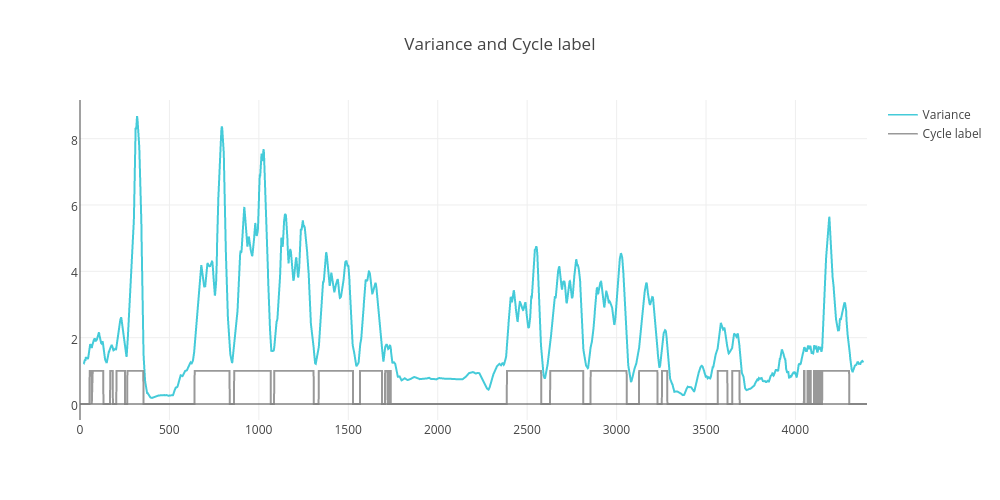

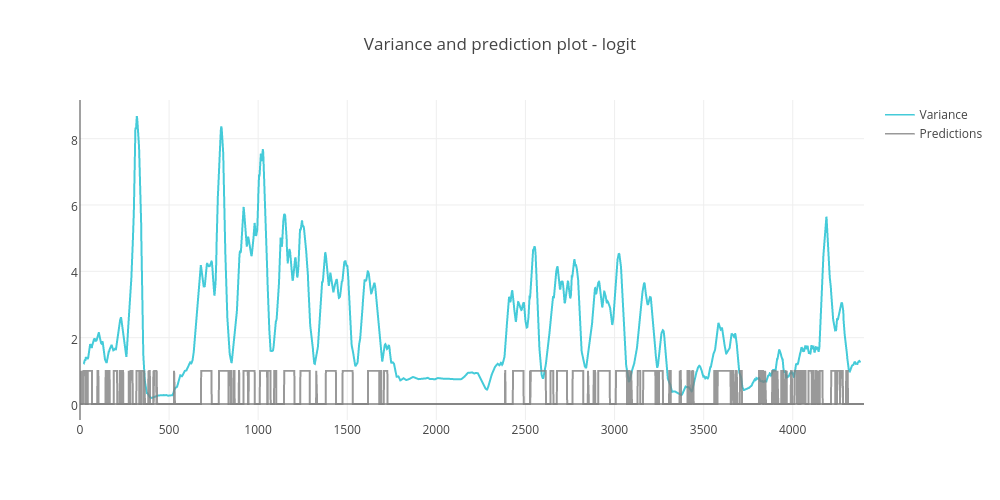

In [46]:
#Predictions for the test data using least squares regression
test_smoothed['preds_logit'] = pd.DataFrame(logit_fit_model.predict(test_appended_data[['ax','ax_L1','ax_L2','ax_L3','ay_L1','ay_L2','ay_L3','az_L1','az_L2','az_L3','ay','az']]))
test_smoothed['preds_logit_bin'] = np.where(test_smoothed['preds_logit'] > 0.5,1,0)

target_names = ['class 0', 'class 1']
print(classification_report(test_smoothed['cycle'],test_smoothed['preds_logit_bin'], target_names= target_names))

### Logistic regression with a subset of significant features
   Another logistic model with a subset of significant features obtained from the p values in the previous complex logistic model is built. The results are similar. Hence we prefer this simpler model.  

In [50]:
logit_model_ss = sm.Logit(appended_data['cycle'], appended_data[['ax','ay_L3','ay','az']])
logitss_fit_model = logit_model_ss.fit()
print(logitss_fit_model.summary())
#Predictions for the test data using least squares regression
test_smoothed['preds_logitss'] = pd.DataFrame(logitss_fit_model.predict(test_appended_data[['ax','ay_L3','ay','az']]))
test_smoothed['preds_logitss_bin'] = np.where(test_smoothed['preds_logitss'] > 0.5,1,0)

target_names = ['class 0', 'class 1']
print(classification_report(test_smoothed['cycle'],test_smoothed['preds_logitss_bin'], target_names= target_names))

Optimization terminated successfully.
         Current function value: 0.663130
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  cycle   No. Observations:                 4552
Model:                          Logit   Df Residuals:                     4548
Method:                           MLE   Df Model:                            3
Date:                Fri, 28 Apr 2017   Pseudo R-squ.:                 0.04326
Time:                        01:52:03   Log-Likelihood:                -3018.6
converged:                       True   LL-Null:                       -3155.1
                                        LLR p-value:                 6.939e-59
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ax             0.2191      0.026      8.571      0.000       0.169       0.269
ay_L3         -0.0831      0.

### 1 nearest neighbor with Dynamic Time Warping
To improve the least squares, a classification with 1 nearest neighbor was performed. This assigns the test data point a label based on the nearest train data point and the proximity is calculated using Dynamic Time Warping. 

In [13]:
#function for DTW distance calculation
def custom_dist(x,y):
    dist, path = fastdtw(x, y, dist = euclidean)
    return dist

#training a knn classifier
X = smoothed_cycles[['ax','ay','az']]
Y = smoothed_cycles['cycle']
nbrs = KNeighborsClassifier(n_neighbors=1,metric=custom_dist)
nbrs.fit(X, Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function custom_dist at 0x7f70e4aaf9b0>,
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

Predictions on test data was made using the model built with the tri-axial test data. 

#### Predictions and evaluation
   An improvement in all the evaluation metrics can be observed in the 1NN method when compared with the ols regression method. Specifically, the class 1 prediction (cycle detection) has improved.

In [14]:
#predictions on test data
test_smoothed['preds'] = nbrs.predict(test_smoothed[['ax','ay','az']])

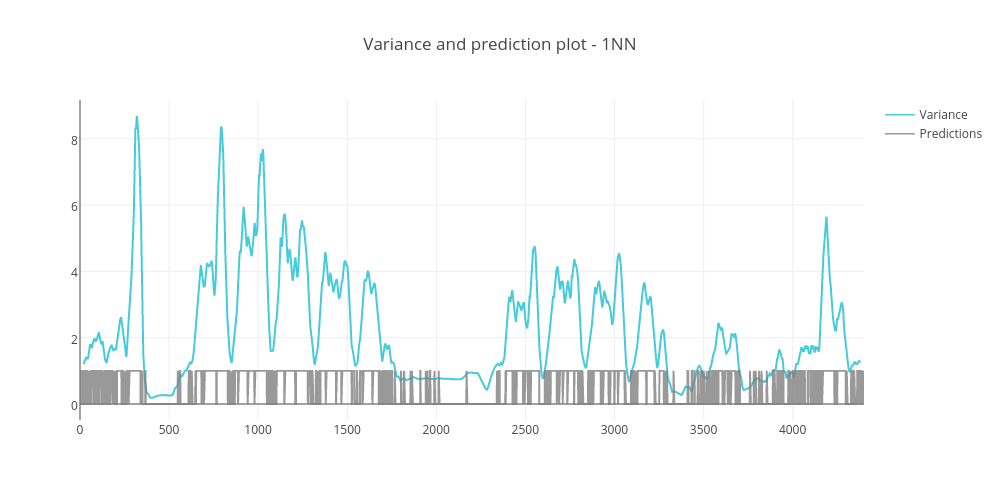

In [16]:
#super imposed plot of variance and cycles predicted from triaxial data by 1NN
def plot_preds_1nn(df):
    trace_x = go.Scatter(
                y=df['var'],
                name = "Variance",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

    trace_y = go.Scatter(
                y=df['preds'],
                name = "Predictions",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)
    data = [trace_x,trace_y]

    layout = dict(
        title = "Variance and prediction plot - 1NN",
        xaxis = dict(
            range = ['0000-00-00 00:00:00.006','0000-00-00 00:00:32'])
    )

    fig = dict(data=data, layout=layout)
    return fig

fig6 = plot_preds_1nn(test_smoothed)
#py.iplot(fig5, filename = "Variance and prediction plot - 1NN")
py.image.ishow(fig6,width=1000)

In [17]:
#Evaluating the model
print(classification_report(test_smoothed['cycle'],test_smoothed['preds'], target_names= target_names))


             precision    recall  f1-score   support

    class 0       0.85      0.84      0.85      2220
    class 1       0.84      0.85      0.85      2181

avg / total       0.85      0.85      0.85      4401



## References
   1. http://ieeexplore.ieee.org/document/7376775/
   2. http://ieeexplore.ieee.org/document/7885511/

## Possible future work
   1. Include gyroscope data, estimate the length of the cycle and 
   2. Spectral features such wavelet transforms, fourier decomposition, chebyshev coefficients and classifying/clustering by ensemble methods
   3. LSTM or RNN to learn the activity in sensor data 
   